<a href="https://colab.research.google.com/github/xiaoya27/Satellite-buildings-semantic-segmentation/blob/main/BuildingsData_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/workingfolder/2021/

/content/drive/MyDrive/workingfolder/2021


# Installation and Imports

In [4]:
!pip install neptune-client==0.4.130

import neptune
from google.colab import output
output.clear() 

In [5]:
neptune.init(
    api_token="xx=",
    project_qualified_name="xiaoya27/BuildingSegmentation"
)

Project(xiaoya27/BuildingSegmentation)

In [6]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"
!pip install -U segmentation-models
output.clear() 

In [7]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np

In [8]:
from PIL import Image
import os
import keras
import random
from tensorflow.keras.utils import Sequence
import cv2
import albumentations as A
import albumentations.augmentations.functional as F
import copy
%env SM_FRAMEWORK=tf.keras
# solution https://github.com/qubvel/segmentation_models/issues/374
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


# Parameters Setup


In [9]:
params={}
params['BATCH_SIZE'] = 8
params['n_classes'] = 1

params['BACKBONE'] = 'efficientnetb3'
params['CLASSES'] = ['building']
params['LR'] = 0.0001
# define network parameters
params['n_classes'] = 1 if len(params['CLASSES']) == 1 else (len(params['CLASSES']) + 1)  # case for binary and multiclass segmentation
params['activation'] = 'sigmoid' if params['n_classes'] == 1 else 'softmax'

# Build DataLoader

In [10]:
images_directory = "kaggle/building_data/src/"
masks_directory =  'kaggle/building_data/label/'
images_filenames = list(sorted(os.listdir(images_directory)))
#correct_images_filenames = [i for i in images_filenames if Image.open(os.path.join(images_directory, i)) is not None]

In [11]:
data_size = len(images_filenames)
random.shuffle(images_filenames)
train_size = round(0.95*data_size)
train_images_filenames = images_filenames[:train_size]
val_images_filenames = images_filenames[train_size:]

print(len(train_images_filenames), len(val_images_filenames))

5728 302


In [12]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 0.0] = 0.0
    mask[mask>0] = 1.0
    #Add new dimensions with np.newaxis
    return mask[:, :, np.newaxis]
#tf.image.resize(np.array(train_label), (256, 256), method='nearest')

In [13]:
# ref to https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/

class BuildingDataset(keras.utils.Sequence):
    def __init__(self, images_filenames, images_directory, masks_directory,transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform
    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename), cv2.IMREAD_UNCHANGED,)
        mask = preprocess_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

In [14]:
class Dataloader(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [15]:

from albumentations import (Resize,Normalize,Blur, Compose, HorizontalFlip, HueSaturationValue,
                            IAAEmboss, IAASharpen, JpegCompression, OneOf,
                            RandomBrightness, RandomBrightnessContrast,
                            RandomContrast, RandomCrop, RandomGamma,
                            RandomRotate90, RGBShift, ShiftScaleRotate,
                            Transpose, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion)

train_transform= Compose([
        Resize(256, 256),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.1),
        Transpose(p=0.5),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.25),
        RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.1),
        Normalize()
    ], p = 1)
#preprocess_input = sm.get_preprocessing(params['BACKBONE'])
val_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize()]
)

In [16]:

train_dataset = BuildingDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform)

val_dataset = BuildingDataset(val_images_filenames, images_directory, masks_directory, transform=val_transform)

train_dataloader = Dataloader(train_dataset, batch_size=params['BATCH_SIZE'], shuffle=True)
valid_dataloader = Dataloader(val_dataset, batch_size=params['BATCH_SIZE'], shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (params['BATCH_SIZE'], 256, 256, 3)
assert train_dataloader[0][1].shape == (params['BATCH_SIZE'], 256, 256, params['n_classes'])

In [17]:
#train_dataloader[0]
#for i in train_dataset.transform: 
#  print(i)

In [18]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask.reshape(256,256), interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

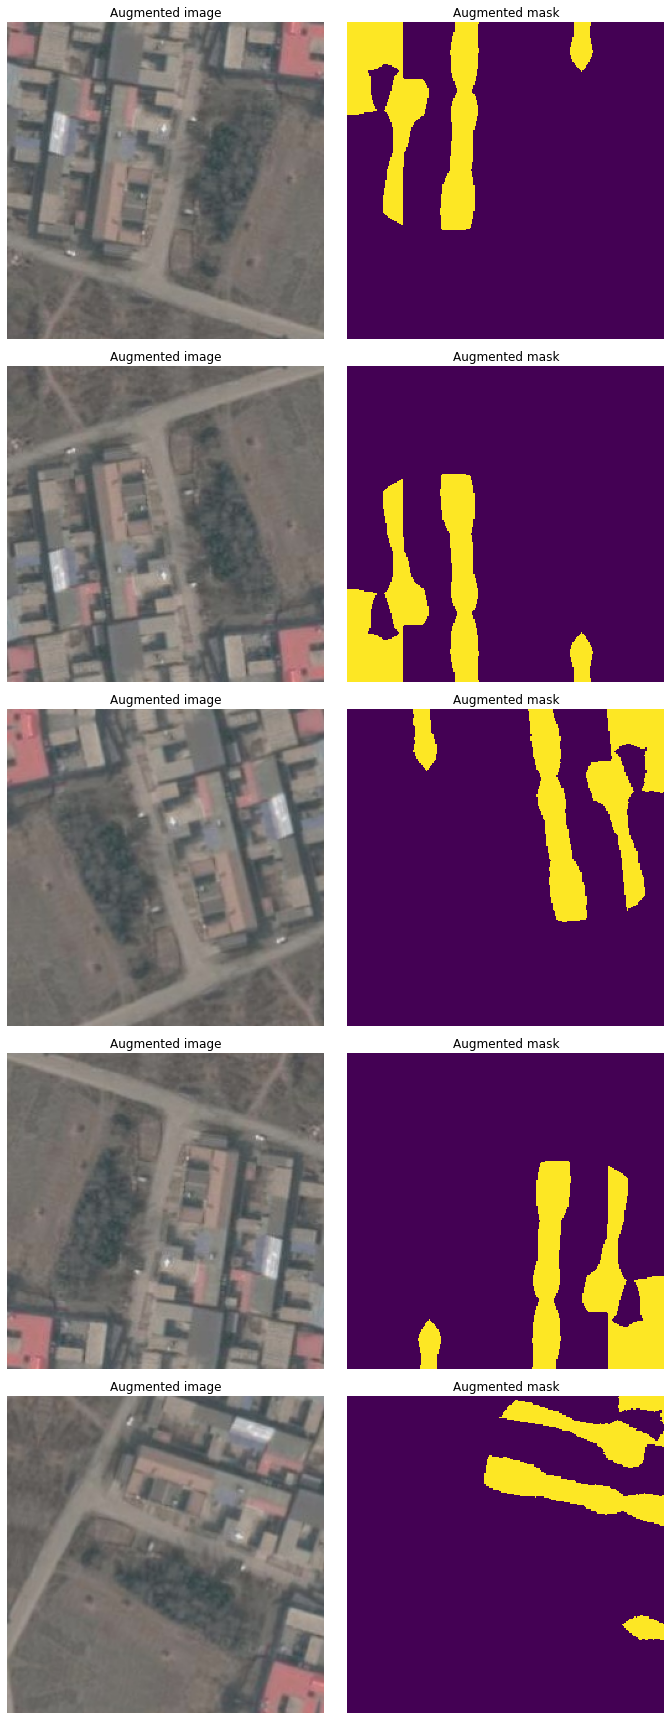

In [19]:
visualize_augmentations(train_dataset, idx=73)

# Model Tracking initialization

In [20]:
class NeptuneLogger(Callback):

    def on_batch_end(self, batch, logs={}):
        for log_name, log_value in logs.items():
            neptune.log_metric(f'batch_{log_name}', log_value)

    def on_epoch_end(self, epoch, logs={}):
        for log_name, log_value in logs.items():
            neptune.log_metric(f'epoch_{log_name}', log_value)

In [21]:
# define optomizer
optim = keras.optimizers.Adam(params['LR'])

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if params['n_classes'] == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [22]:
neptune.create_experiment(name='BuildingsData-UNet',
                          params=params,
                          tags=['Tensorflow'],
                          )

https://ui.neptune.ai/xiaoya27/BuildingSegmentation/e/BUIL-6


Experiment(BUIL-6)

#Model

In [23]:
with tf.device('/device:GPU:0'):
  #create model
  model = sm.Unet(params['BACKBONE'], classes=params['n_classes'], activation=params['activation'])
  # to deal with ValueError: Layer sequential_20 expects 1 inputs, but it received 2 input tensors, change get item value from list to tuple

  # compile keras model with defined optimizer, loss and metrics
  model.compile(optim, total_loss, metrics)
  # define callbacks for learning rate scheduling and best checkpoints saving
  callbacks = [
      keras.callbacks.ModelCheckpoint('./saved_model/best_model_unet.h5', save_weights_only=True, save_best_only=True, mode='min'),
      keras.callbacks.ReduceLROnPlateau(),
      NeptuneLogger()
  ]
  # train model
  history = model.fit(train_dataloader,shuffle =True,
                    epochs=20, workers=4, use_multiprocessing=True,
                    validation_data =valid_dataloader, 
                    verbose = 1, callbacks=callbacks)

Epoch 1/20
716/716 [==============================] - 231s 297ms/step - loss: 0.6034 - iou_score: 0.4298 - f1-score: 0.5878 - val_loss: 0.3851 - val_iou_score: 0.6155 - val_f1-score: 0.7583
Epoch 2/20
716/716 [==============================] - 214s 297ms/step - loss: 0.3955 - iou_score: 0.5825 - f1-score: 0.7332 - val_loss: 0.3381 - val_iou_score: 0.6388 - val_f1-score: 0.7758
Epoch 3/20
716/716 [==============================] - 214s 298ms/step - loss: 0.3519 - iou_score: 0.6205 - f1-score: 0.7631 - val_loss: 0.3234 - val_iou_score: 0.6513 - val_f1-score: 0.7849
Epoch 4/20
716/716 [==============================] - 215s 299ms/step - loss: 0.3261 - iou_score: 0.6431 - f1-score: 0.7804 - val_loss: 0.3066 - val_iou_score: 0.6648 - val_f1-score: 0.7953
Epoch 5/20
716/716 [==============================] - 214s 298ms/step - loss: 0.3152 - iou_score: 0.6526 - f1-score: 0.7875 - val_loss: 0.3173 - val_iou_score: 0.6656 - val_f1-score: 0.7956
Epoch 6/20
716/716 [==============================

In [24]:
model.summary()
neptune.stop()

##got warning 
#cuz shuffle at train end
#from tensorflow.keras.utils import plot_model
#plot_model(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
______________________________________________________________________________________________

# Testing

In [ ]:
# last

images = os.listdir("kaggle/building_data/test/src/")
for path in images:
    test_image_path = 'kaggle/building_data/test/src/' + path
    if path.split('.')[1] == "tiff":
        path = path.replace("tiff","tif")
    test_label_path = 'kaggle/building_data/test/label/' + path

    # print(test_image_path)
    test_image = Image.open(test_image_path).convert('RGB')
    test_label = Image.open(test_label_path)
    print(np.unique(np.array(test_label)))
    img_h, img_w, _ = np.array(test_image).shape
    if img_h <= 256 and img_w <= 256:
        plt.figure(figsize=(10,10))
        plt.subplot(1, 2, 1)
        plt.imshow(test_image)
        plt.subplot(1, 2, 2)
        plt.imshow(test_label)
        plt.show()
    else:
        stride = 256
        # 使用原尺寸
        if img_h % 256 == 0:
            padding_h = img_h
            padding_w = img_w
        else:  # 将图像的尺寸补齐为256的倍数
            padding_h = (img_h // stride + 1) * stride
            padding_w = (img_w // stride + 1) * stride
         
        plt.figure(figsize=(16,9))
        plt.subplot(1, 3, 1).set_title("original map (" + str(img_h) + "x" + str(img_w) +")")
        plt.imshow(test_image)
        plt.subplot(1, 3, 2).set_title("label map")
        plt.imshow(test_label)
        plt.show()